### Иморт необходимых библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
import cv2
import time
import seaborn as sns
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

In [2]:
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from skimage.feature import hog
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Функции-помощники для обработки данных

In [3]:
def load_data(num_classes = 43):

    """
    Loads Train dataset
    
    in: number of classes to work with
    out: np.arrays of objects (X),
         target (y) and labels (labels)
    """
    
    dir_loc_List = []
    labels = []
    
    # creating directory list to read data from each class folder
    for class_Number in range(0, num_classes):
            dir_loc_List.append('data/Train/' + str(class_Number) + '/*.png')
            labels.append(str(class_Number))

    class_counter = 0
    for dir_loc in dir_loc_List:
        
        # reading from each class directory folder
        if class_counter == 0:
            filelist = glob.glob(dir_loc)
            data_GTSRB = np.array([cv2.imread(fname) for fname in filelist], dtype=object)
            data_class = np.full((len(data_GTSRB), 1), class_counter)
            class_counter += 1
        else:
            filelist = glob.glob(dir_loc)
            data_GTSRB = np.concatenate((data_GTSRB, np.array([cv2.imread(fname) for fname in filelist], dtype=object)))
            data_class = np.concatenate((data_class, (np.full((len(np.array([cv2.imread(fname) for fname in filelist],  dtype=object)), 1), class_counter))), dtype=object)
            class_counter += 1

    return data_GTSRB, data_class, labels

In [4]:
def gray_convert(input_data):
    """ 
    converts input images to grayscale
     
    in: np.array of image data in RGB
    out: np.array of image data in grayscale
    """
    
    data_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in input_data], dtype=object)

    return data_gray

In [5]:
def avg_size(x_data):
    """ 
    gets the minimum pixel length (images are not squares).

    in: np.array of image data
    out: average size of image in dataset 
    """
    
    size_List = []
    for data in x_data:
        size_List.append(min(data.shape))
    
    return (int(np.average(size_List)), int(np.average(size_List)))

In [6]:
def resize_all(input_data, size = (50, 50)):
    """ 
    resizes input images.

    in: np.array of image data, desired size of images
    out: np array of image data in desired size
    """
    
    data_resized = np.array([cv2.resize(img, size) for img in input_data], dtype=object).astype(float)

    return data_resized

In [7]:
def clf_reshape(input_data):
    """ 
    image flattening, reshaping the data to the (samples, feature) matrix format 
    
    in: np.array of image data
    out: reshaped np.array of image data
    """
    
    n_samples = len(input_data)
    data_reshaped = input_data.reshape((n_samples, -1))
    
    return data_reshaped

In [8]:
def hog_compute(input_data):
    """ 
    computes HOG features of input images

    in: reshaped np.array of image data
    out: np.array with HOG features
    """
    
    start_ts = time.time()
    hog_output = [hog(img, pixels_per_cell = (2, 2), visualize = True) for img in input_data]
    data_hog = [hog_img for out, hog_img in hog_output]
    
    print("HOG feature computation runtime:", time.time()-start_ts)

    return data_hog

## Работа с тренировочным датасетом 
Конвертируем в серый цвет, вычисляем HOG фичи, решейпим изображения.
После разбиваем на тренировочную и валидационную выборку и тренируем SVM на полученном трейне.

### Конвертируем в серый цвет

In [9]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = load_data(num_classes)
gray_GTSRB = gray_convert(data_GTSRB)

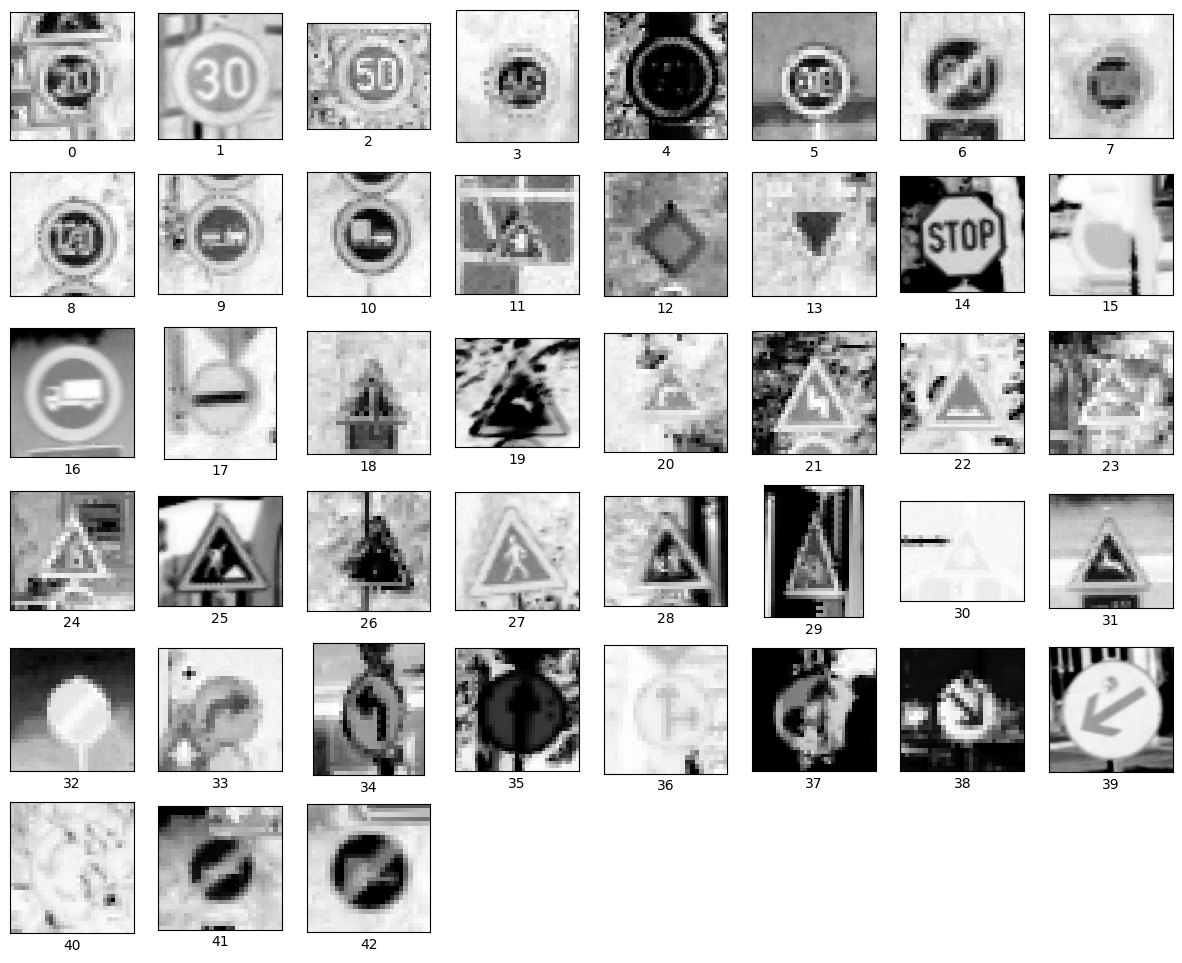

In [10]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

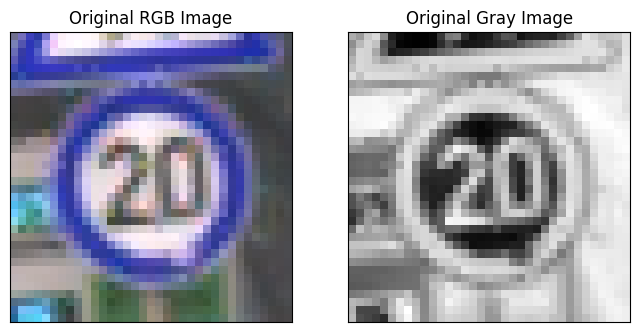

In [11]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[10], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[10], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

### Вычисляем HOG фичи

In [13]:
data_hog = hog_compute(gray_GTSRB[:30])

HOG feature computation runtime: 3.636366367340088


In [10]:
data_hog = hog_compute(gray_GTSRB)

HOG feature computation runtime: 4571.232129812241


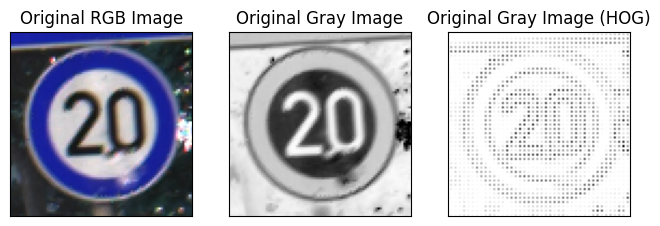

In [14]:
# original, post grayscale and HOG comparison
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[25], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[25], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_hog[25], cmap = plt.cm.binary)
plt.title('Original Gray Image (HOG)')
plt.show()

Выглядит неплохо!

### Ресайз изображений к одному размеру, решейп для классификации

In [17]:
avg_size(data_hog)

(49, 49)

In [18]:
# resizing
hog_resize_data = resize_all(data_hog, size = (50, 50))

# reshaping for classifications
hog_reshaped = clf_reshape(hog_resize_data)

# normalizing data, RGB/grayscale images are out of 255
#norm_hog_reshaped = hog_reshaped / 255.0

In [16]:
np.save("Train_HOG_03-12-23.npy", hog_resize_data)

In [17]:
hog_resize_data = np.load("Train_HOG_03-12-23.npy")
hog_reshaped = clf_reshape(hog_resize_data)

Выведем знаки с измененными размерами

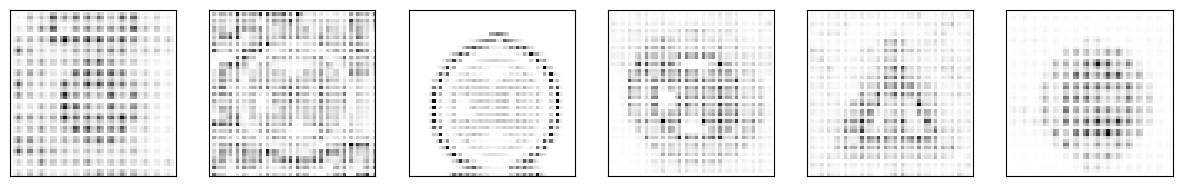

In [19]:
# plot post resize HOG 
img_num_List = [0, 333, 888, 6437, 30000, 12300]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(hog_resize_data[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

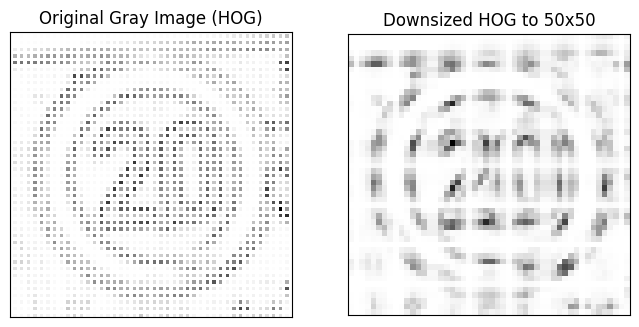

In [20]:
# original HOG image and after downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_hog[25], cmap = plt.cm.binary)
plt.title('Original Gray Image (HOG)')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(hog_resize_data[25], cmap = plt.cm.binary)
plt.title('Downsized HOG to 50x50')
plt.show()

### Разбивка на тренировочную и валидационную выборку

In [20]:
# 80% train 20% test split
Xtrain, Xtest, ytrain, ytest = train_test_split(hog_reshaped, data_class,\
                                                          stratify = data_class, test_size = 0.2, random_state=42)

In [21]:
# 80% train 20% test split no stratify
Xtrain, Xtest, ytrain, ytest = train_test_split(hog_reshaped, data_class, test_size = 0.2, random_state=42)

### Распределение классов в тренировочной и валидационной выборке

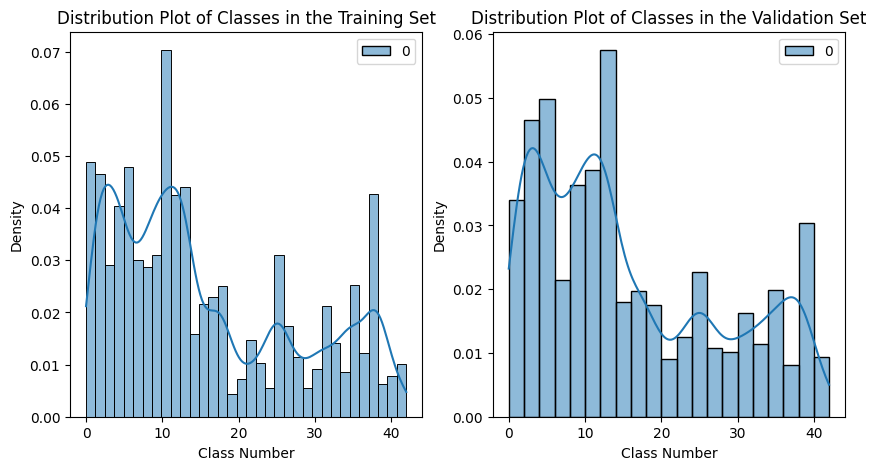

Total of 31367 images in the training data
Total of 7842 images in the validation data
80.00 percent training set, 20.00 percent validation set


In [22]:
# class distribution after split
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.histplot(ytrain, kde=True, stat="density")
plt.title('Distribution Plot of Classes in the Training Set')
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.histplot(ytest, kde=True, stat="density")
plt.title('Distribution Plot of Classes in the Validation Set')
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(Xtrain) + len(Xtest)
print(f'Total of {len(Xtrain)} images in the training data')
print(f'Total of {len(Xtest)} images in the validation data')
print(f'{(len(Xtrain)/tot_len*100):.2f} percent training set, '
      f'{(len(Xtest)/tot_len*100):.2f} percent validation set')


### SVM на полученном трейне

In [23]:
ytrain = ytrain.astype(float)
ytrain = np.ravel(ytrain,order='C')

In [24]:
#import dpctl
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [28]:
# sci-kit SVM

# accuracy list
acc_Dict = {}

start_ts = time.time()
model = SVC(probability=True)
scores = cross_validate(model, Xtrain, ytrain, scoring = 'accuracy', cv = 5)
scores_result = scores['test_score']
                                                                                                                               
print("SVM Classifier Acc: %0.3f (+/- %0.2f)" % (scores_result.mean(), scores_result.std() * 2))

print("CV Runtime:", time.time()-start_ts)
acc_Dict['SVM Classifier'] = [scores_result.mean(), scores_result.std() * 2]

SVM Classifier Acc: 0.620 (+/- 0.00)
CV Runtime: 28001.218012809753


In [29]:
scores

{'fit_time': array([5700.89134741, 7091.74514294, 4262.76444697, 4993.36423492,
        4524.7808516 ]),
 'score_time': array([385.56364417, 383.91361523, 222.82243347, 224.50755596,
        210.45322132]),
 'test_score': array([0.61619382, 0.61874402, 0.62298741, 0.62107445, 0.62091503])}

### Подбор оптимальных гиперпараметров

In [25]:
# preparing a parameter grid
param_grid = {"C": sp_uniform(0.0001, 10), "kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "gamma": sp_uniform(0.0001, 1)}

# creating and fitting a SVM Classifier, testing random param_grids
start_ts = time.time()
model = SVC()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(Xtrain, ytrain)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)


CV Runtime: 48916.20076060295
The best RandomizedSearchCV score: 0.6891634589619349
The best estimator:
 SVC(C=7.379643995135198, gamma=0.8435555028851278, kernel='linear')


CV Runtime: 48916.20076060295
The best RandomizedSearchCV score: 0.6891634589619349
The best estimator:
 SVC(C=7.379643995135198, gamma=0.8435555028851278, kernel='linear')

### Экспорт модели

In [36]:
data = {
     'best_model': rsearch.best_estimator_,
     'params_model': rsearch.best_params_,
     'score_model': rsearch.best_score_,
     'classes_model': rsearch.classes_,
     'cv_results': rsearch.cv_results_
 }

with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

### Результаты на валидационной выборке

In [26]:
model = SVC(C=7.3796, gamma=0.843, kernel='linear')
model.fit(Xtrain, ytrain)
predictions = model.predict(Xtest)

In [140]:
model = SVC(C=3.86, gamma=0.516, kernel='linear')
model.fit(Xtrain, ytrain)
predictions = model.predict(Xtest)

In [30]:
ytest = np.ravel(ytest,order='C')
ytest = ytest.astype(float)
predictions = np.ravel(predictions,order='C')

In [28]:
predictions = pd.DataFrame(predictions)
len(predictions[0].unique())

43

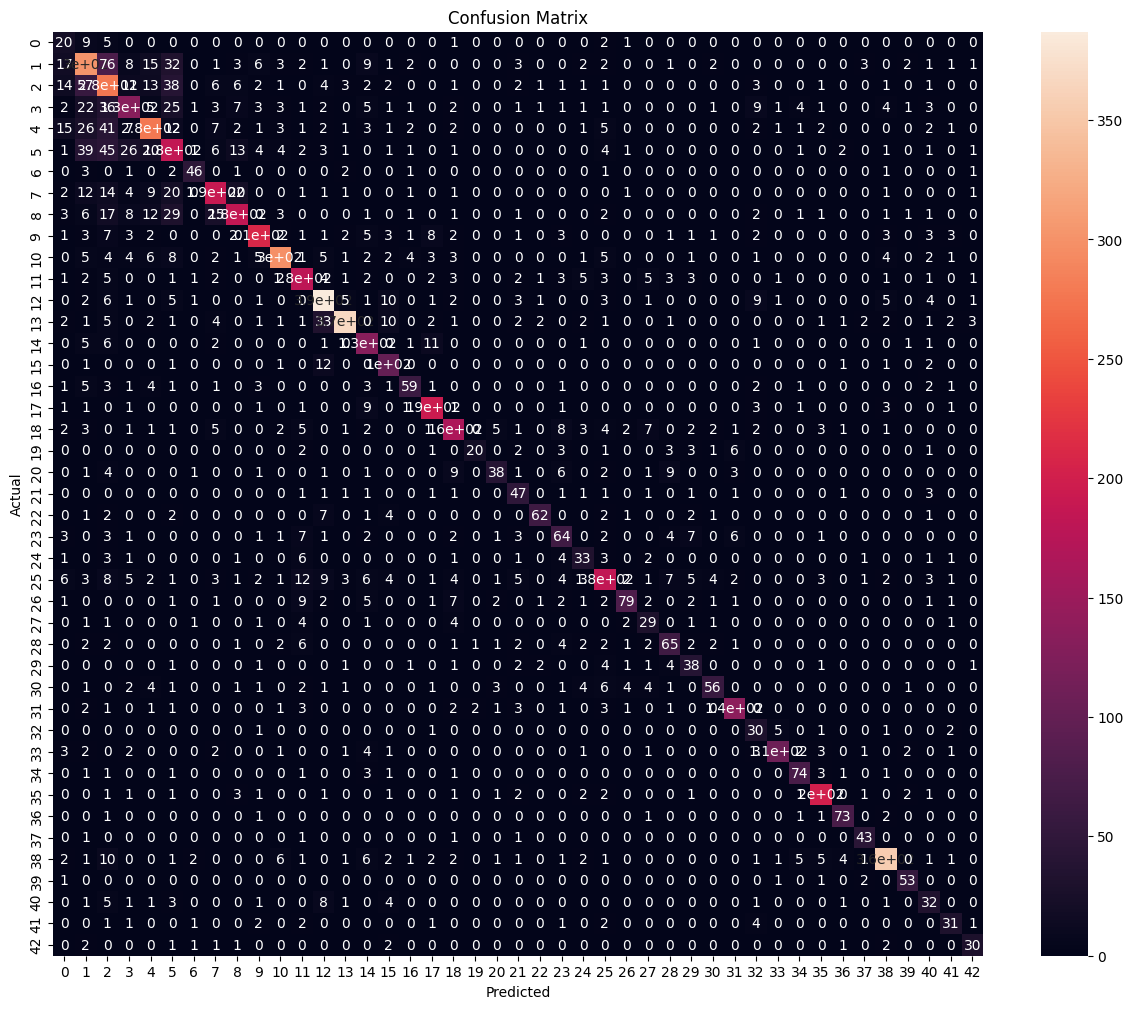

In [32]:
conf_matrix = confusion_matrix(ytest, predictions)
plt.figure(figsize = (15, 12))
sns.heatmap(conf_matrix, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

По матрице выше видно, что модель больше всего путается в первых 5-8 классах. Даже выделяется отдельная зона в матрице. 

Это связано с тем, что все эти классы - знаки ограничения скорости, и различаются только первой цифрой на знаке.

Их действительно легко перепутать на фотографиях с низким разрешением, с неудачными условиями съемки.

In [33]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

         0.0       0.20      0.53      0.29        38
         1.0       0.58      0.61      0.59       496
         2.0       0.47      0.62      0.53       450
         3.0       0.59      0.47      0.53       280
         4.0       0.74      0.66      0.70       418
         5.0       0.49      0.51      0.50       364
         6.0       0.82      0.78      0.80        59
         7.0       0.73      0.68      0.70       278
         8.0       0.75      0.61      0.68       301
         9.0       0.84      0.78      0.81       268
        10.0       0.89      0.81      0.85       370
        11.0       0.71      0.77      0.74       236
        12.0       0.79      0.86      0.83       450
        13.0       0.93      0.81      0.87       452
        14.0       0.64      0.81      0.72       162
        15.0       0.66      0.84      0.74       120
        16.0       0.77      0.66      0.71        90
        17.0       0.84    

**Это лучшие результаты из проведенных мной тестов.**

Ниже приведены результаты на тестовой выборке, а также эксперименты по улучшению результата с помощью других параметров сжатия фотографий и рассчета фич HOG.

### Результаты на тесте

In [9]:
def load_data_test():

    dir_loc_List = []
    test_data_class = []
    test_data_GTSRB = []

    with open('data/Test.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers

        for row in csv_reader:
            dir_loc_List.append('data/' + row[-1])
            test_data_class.append([int(row[-2])])

    this_data_GTSRB = np.array([cv2.imread(fname) for fname in dir_loc_List], dtype=object)
    test_data_GTSRB.append(this_data_GTSRB)

    test_data_GTSRB = np.array(test_data_GTSRB)
    test_data_class = np.array(test_data_class, dtype=object)

    return test_data_GTSRB[0], test_data_class

In [195]:
data_class

array([[0],
       [0],
       [0],
       ...,
       [42],
       [42],
       [42]], dtype=object)

In [204]:
test_data_class

array([[16],
       [1],
       [38],
       ...,
       [6],
       [7],
       [10]], dtype=object)

In [10]:
# reading the GTSRB test data utilizing the custom python script
test_GTSRB, test_class = load_data_test()
test_gray_GTSRB = gray_convert(test_GTSRB) # grayscaled

In [11]:
import lzma

with lzma.open('../services/model/lzma_hog_proba.xz', 'rb') as f:
    model_data = pickle.load(f)

In [14]:
model_data

{'best_model': SVC(C=7.3796, gamma=0.843, kernel='linear', probability=True)}

In [12]:
test_hog = hog_compute(test_gray_GTSRB)

HOG feature computation runtime: 1780.4866898059845


In [13]:
# resizing
hog_resize_test = resize_all(test_hog, size = (50, 50))

# reshaping for classifications
hog_test_reshaped = clf_reshape(hog_resize_test)

In [15]:
Xtest_full = hog_test_reshaped
ytest_full = test_class
predictions_full = model_data['best_model'].predict(Xtest_full)

In [16]:
ytest_full = np.ravel(ytest_full,order='C')
ytest_full = ytest_full.astype(float)
predictions_full = np.ravel(predictions_full,order='C')

In [17]:
accuracy_score(predictions_full, ytest_full)

0.6053840063341251

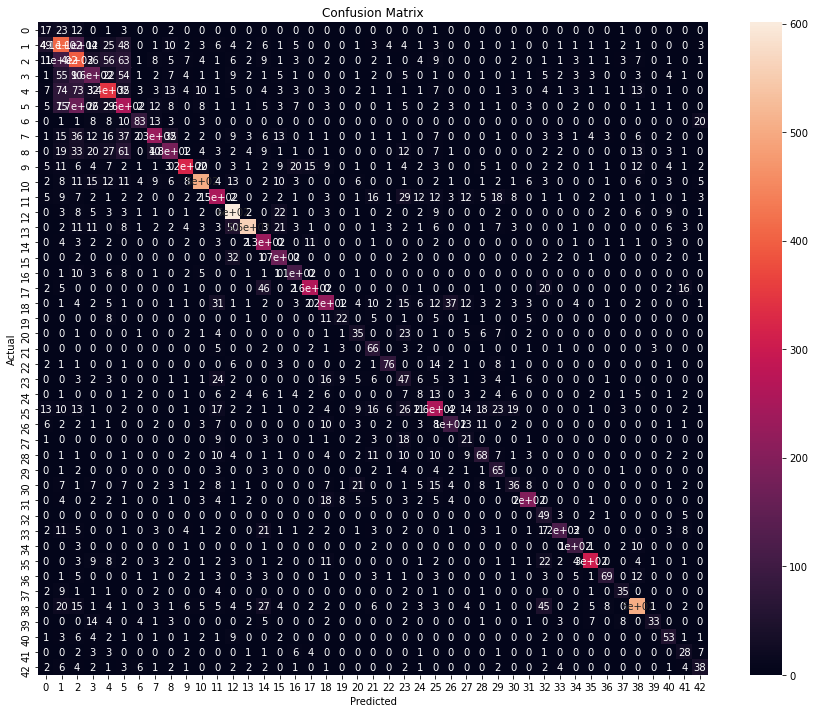

In [18]:
conf_matrix = confusion_matrix(ytest_full, predictions_full)
plt.figure(figsize = (15, 12))
sns.heatmap(conf_matrix, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

In [19]:
print(classification_report(ytest_full, predictions_full))

              precision    recall  f1-score   support

         0.0       0.13      0.28      0.18        60
         1.0       0.46      0.57      0.51       720
         2.0       0.38      0.53      0.44       750
         3.0       0.40      0.36      0.38       450
         4.0       0.57      0.52      0.55       660
         5.0       0.41      0.41      0.41       630
         6.0       0.73      0.55      0.63       150
         7.0       0.67      0.51      0.58       450
         8.0       0.64      0.41      0.50       450
         9.0       0.83      0.67      0.74       480
        10.0       0.85      0.76      0.81       660
        11.0       0.60      0.60      0.60       420
        12.0       0.78      0.87      0.82       690
        13.0       0.93      0.78      0.85       720
        14.0       0.57      0.86      0.69       270
        15.0       0.61      0.79      0.69       210
        16.0       0.63      0.74      0.68       150
        17.0       0.86    

### Пробуем сбалансировать выборку

In [ ]:
model = SVC(C=3.86, gamma=0.516, kernel='linear')
model.fit(Xtrain, ytrain)
predictions = model.predict(Xtest)

In [69]:
def under_sample(x_data, y_data):

    # obtaining class labels and their counts
    labels_arr, class_count = np.unique(y_data, return_counts = True)

    counter = 0
    
    # for each class label, performing random under-sampling using the indices
    for cls in labels_arr:
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
        cls_idx = get_indexes(cls, y_data)
        
        # obtaining all image instances for the class label "cls"
        reshaped_subset = x_data[cls_idx]
        class_subset = y_data[cls_idx]
        
        # obtaining the indices for the purpose of random sampling without replacement
        idx = np.random.choice(np.arange(len(reshaped_subset)), min(class_count), replace = False)
        
        if counter == 0:
            # applying the randomly sampled indices on the subsets
            x_und_smpl_data = reshaped_subset[idx]
            y_und_smpl_data = class_subset[idx]
            counter += 1
        else:
            # applying the randomly sampled indices on the subsets
            x_und_smpl_data = np.concatenate((x_und_smpl_data, reshaped_subset[idx]))
            y_und_smpl_data = np.concatenate((y_und_smpl_data, class_subset[idx]))
            counter += 1

    return x_und_smpl_data, y_und_smpl_data

In [134]:
# resizing
hog_resize_data2 = resize_all(data_hog, size = (16, 16))

# reshaping for classifications
hog_reshaped2 = clf_reshape(hog_resize_data2)

# normalizing data, RGB/grayscale images are out of 255
norm_hog_reshaped2 = hog_reshaped2 / 255.0

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20%
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(norm_hog_reshaped2, data_class,\
                                                                  stratify = data_class, \
                                                                  test_size = 0.055)

# random under-sampling
Xtrain_un, ytrain_un = under_sample(Xtrain2, ytrain2)

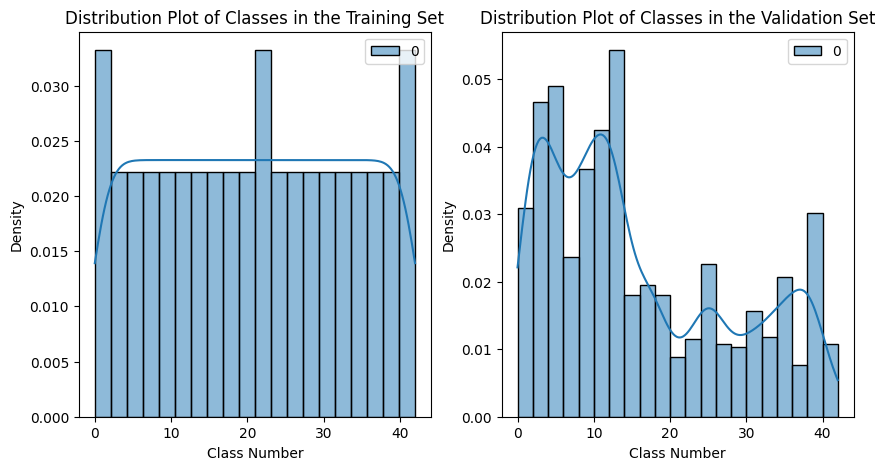

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [135]:
# class distribution after split
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.histplot(ytrain_un, kde=True, stat="density")
plt.title('Distribution Plot of Classes in the Training Set')
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.histplot(ytest, kde=True, stat="density")
plt.title('Distribution Plot of Classes in the Validation Set')
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(Xtrain_un) + len(Xtest2)
print(f'Total of {len(Xtrain_un)} images in the training data')
print(f'Total of {len(Xtest2)} images in the validation data')
print(f'{(len(Xtrain_un)/tot_len*100):.2f} percent training set, '
      f'{(len(Xtest2)/tot_len*100):.2f} percent validation set')

In [137]:
ytrain_un = ytrain_un.astype(float)
ytrain_un = np.ravel(ytrain_un,order='C')

In [138]:
# sci-kit SVM

# accuracy list
acc_Dict = {}

start_ts = time.time()
model = SVC(probability=True)
scores = cross_validate(model, Xtrain_un, ytrain_un, scoring = 'accuracy', cv = 5)
scores_result = scores['test_score']
                                                                                                                               
print("SVM Classifier Acc: %0.3f (+/- %0.2f)" % (scores_result.mean(), scores_result.std() * 2))

print("CV Runtime:", time.time()-start_ts)
acc_Dict['SVM Classifier'] = [scores_result.mean(), scores_result.std() * 2]

SVM Classifier Acc: 0.336 (+/- 0.03)
CV Runtime: 161.66544485092163


In [74]:
# preparing a parameter grid
param_grid = {"C": sp_uniform(0.0001, 10), "kernel": ['linear', 'poly', 'rbf', 'sigmoid'], "gamma": sp_uniform(0.0001, 1)}

# creating and fitting a SVM Classifier, testing random param_grids
start_ts = time.time()
model = SVC()
rsearch = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'accuracy', cv = 5)
rsearch.fit(Xtrain_un, ytrain_un)
print("CV Runtime:", time.time() - start_ts)

# summarizing the results of the random parameter search
print('The best RandomizedSearchCV score:', rsearch.best_score_)
print('The best estimator:\n', rsearch.best_estimator_)


CV Runtime: 101.69603705406189
The best RandomizedSearchCV score: 0.39202762415052383
The best estimator:
 SVC(C=6.1587368368881155, gamma=0.787911448815655)


На сбалансированной выборке accuracy получается хуже.

### Пробуем другие параметры изменения размера картинок
Будем ресайзить не до 50х50, а до 16х16 пикселей

In [11]:
# resizing
hog_resize_small_data = resize_all(data_hog, size = (16, 16))

# reshaping for classifications
hog_reshaped_small = clf_reshape(hog_resize_small_data)

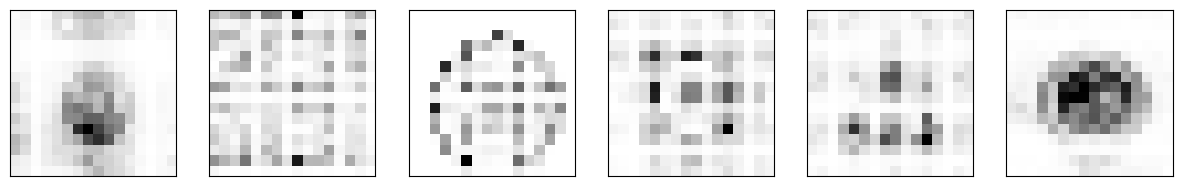

In [12]:
# plot post resize HOG 
img_num_List = [0, 333, 888, 6437, 30000, 12300]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(hog_resize_small_data[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

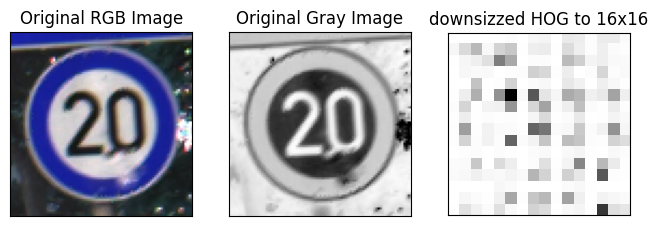

In [16]:
# original, post grayscale and HOG comparison
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[25], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[25], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(hog_resize_small_data[25], cmap = plt.cm.binary)
plt.title('downsizzed HOG to 16x16')
plt.show()

In [21]:
# 80% train 20% test split
Xtrain, Xtest, ytrain, ytest = train_test_split(hog_reshaped_small, data_class,\
                                                          stratify = data_class, test_size = 0.2)

In [22]:
ytrain = ytrain.astype(float)
ytrain = np.ravel(ytrain,order='C')

In [23]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [24]:
# sci-kit SVM

# accuracy list
acc_Dict = {}

start_ts = time.time()
model = SVC(probability=True)
scores = cross_validate(model, Xtrain, ytrain, scoring = 'accuracy', cv = 5)
scores_result = scores['test_score']
                                                                                                                               
print(f"SVM Classifier Acc: {scores_result.mean():.3f} (+/- {(scores_result.std() * 2):.2f})")

print("CV Runtime:", time.time()-start_ts)
acc_Dict['SVM Classifier'] = [scores_result.mean(), scores_result.std() * 2]

SVM Classifier Acc: 0.465 (+/- 0.01)
CV Runtime: 1585.6035537719727


С размером 16х16 результаты получаются хуже, чем с размером 50х50. 

Вероятно, это связано с тем, что многие признаки тех или иных классов знаков просто пропадают при таком сжатии. 

Особенно это актуальнно дляфотографий, у которых изначально был больший размер, чем 16х16.

### Пробуем другие настройки HOG

In [9]:
def hog_compute_2(input_data):
    # computing HOG features of input images
    
    start_ts = time.time()
    hog_output = [hog(img, orientations=9, pixels_per_cell=(8,8),
                      cells_per_block=(2, 2), transform_sqrt=True, visualize = True) for img in input_data]
    data_hog = [hog_img for out, hog_img in hog_output]
    
    print("HOG feature computation runtime:", time.time()-start_ts)

    return data_hog

In [10]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = load_data(num_classes)
gray_GTSRB = gray_convert(data_GTSRB)

In [11]:
data_hog_2 = hog_compute_2(gray_GTSRB)

HOG feature computation runtime: 279.7664940357208


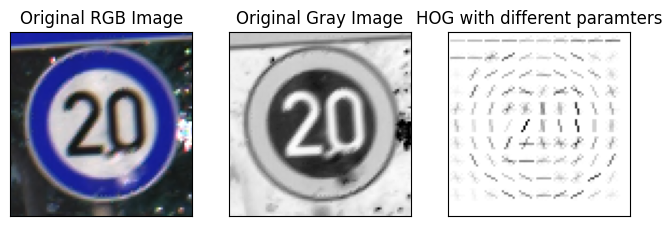

In [14]:
# original, post grayscale and HOG comparison
plt.figure(figsize = (8, 5))
plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[25], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[25], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_hog_2[25], cmap = plt.cm.binary)
plt.title('HOG with different paramters')
plt.show()

In [15]:
# resizing
hog_resize_data_2 = resize_all(data_hog_2, size = (50,50))

# reshaping for classifications
hog_reshaped_2 = clf_reshape(hog_resize_data_2)

# normalizing data, RGB/grayscale images are out of 255
#norm_hog_reshaped = hog_reshaped / 255.0

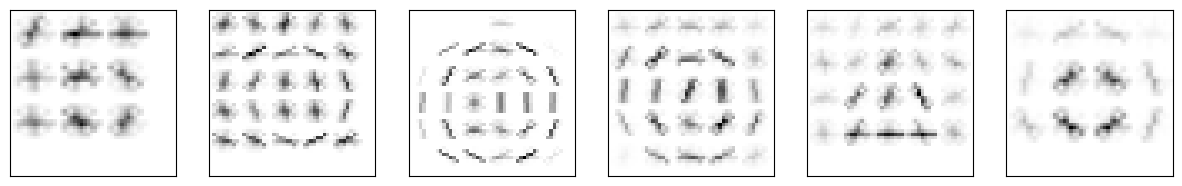

In [16]:
# plot post resize HOG 
img_num_List = [0, 333, 888, 6437, 30000, 12300]
fig = plt.figure(figsize = (15, 6))
for i in range(len(img_num_List)):
    plt.subplot(1, 6, i+1)
    plt.imshow(hog_resize_data_2[img_num_List[i]], cmap = plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
plt.show()

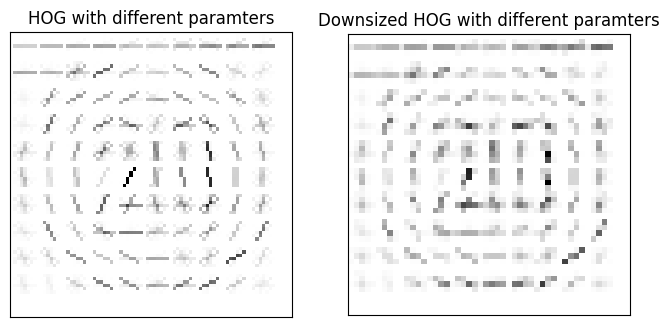

In [17]:
# original HOg image and after downsizing comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_hog_2[25], cmap = plt.cm.binary)
plt.title('HOG with different paramters')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(hog_resize_data_2[25], cmap = plt.cm.binary)
plt.title('Downsized HOG with different paramters')
plt.show()

In [18]:
# 80% train 20% test split
Xtrain, Xtest, ytrain, ytest = train_test_split(hog_reshaped_2, data_class,\
                                                          stratify = data_class, test_size = 0.2)

In [19]:
ytrain = ytrain.astype(float)
ytrain = np.ravel(ytrain,order='C')

In [20]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [21]:
# sci-kit SVM

# accuracy list
acc_Dict = {}

start_ts = time.time()
model = SVC(probability=True)
scores = cross_validate(model, Xtrain, ytrain, scoring = 'accuracy', cv = 5)
scores_result = scores['test_score']
                                                                                                                               
print(f"SVM Classifier Acc: {scores_result.mean():.3f} (+/- {(scores_result.std() * 2):.2f})")

print("CV Runtime:", time.time()-start_ts)
acc_Dict['SVM Classifier'] = [scores_result.mean(), scores_result.std() * 2]

SVM Classifier Acc: 0.522 (+/- 0.01)
CV Runtime: 38425.28969287872


Кросс-валидация показывает accuracy хуже, чем на изначальным параметрах HOG.